In [117]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets._samples_generator import make_blobs
from matplotlib import pyplot as plt

### Univariate Logistic Regression

In [118]:
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=5, random_state=42)
w = [0,1,1]

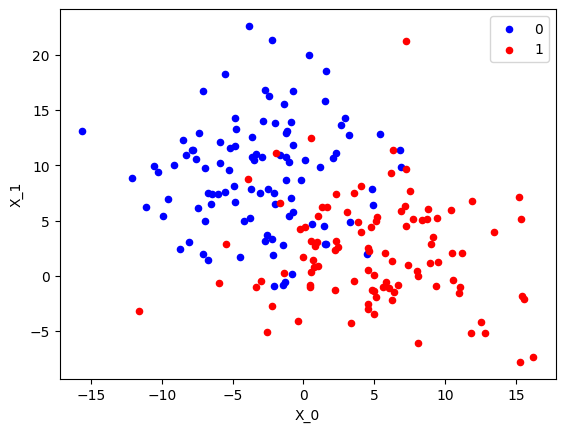

In [119]:
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'blue', 1:'red'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for k, v in grouped:
    v.plot(ax=ax, kind='scatter', x='x', y='y', label=k, color=colors[k])

plt.xlabel('X_0')
plt.ylabel('X_1')
plt.show()

In [120]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))


def hx(w, X):
    z = np.array(w[0] + w[1]*np.array(X[:,0]) + w[2]*np.array(X[:,1]))
    return sigmoid(z)


def compute_loss(w, X, Y):
    y_pred = hx(w,X)
    return -1 * sum(Y*np.log(y_pred) + (1-Y)*np.log(1-y_pred))


def compute_grad(X, Y, y_pred):
    g = [0]*3
    g[0] = -1 * sum(Y*(1-y_pred) - (1-Y)*y_pred)
    g[1] = -1 * sum(Y*(1-y_pred)*X[:,0] - (1-Y)*y_pred*X[:,0])
    g[2] = -1 * sum(Y*(1-y_pred)*X[:,1] - (1-Y)*y_pred*X[:,1])

    return g


def gradient_descent(w, X, Y, lr, epochs):
    for _ in range(epochs):
        y_pred = hx(w, X)
        grad = compute_grad(X, Y, y_pred)
        w[0] -= lr*grad[0]
        w[1] -= lr*grad[1]
        w[2] -= lr*grad[2]

    return w

In [122]:
w = gradient_descent(w, X, y, 1e-3, 200)

compute_loss(w, X, y)

np.float64(59.512336638103406)

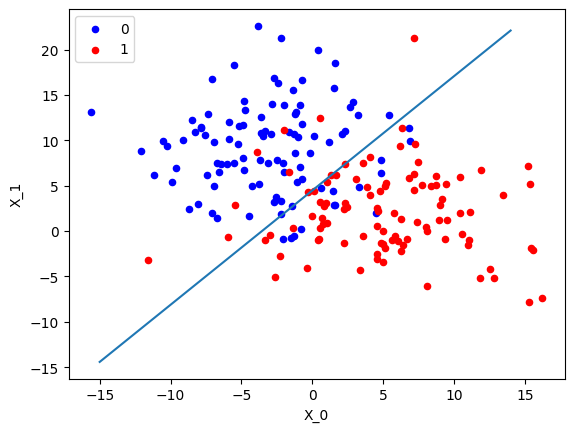

In [123]:
def view_logistic_split(w, X, x_range):
    x = np.array(x_range)
    y = -(w[0] + w[1] * x) / w[2]  # Correct decision boundary equation

    return x, y

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'blue', 1:'red'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for k, v in grouped:
    v.plot(ax=ax, kind='scatter', x='x', y='y', label=k, color=colors[k])

x_view, y_view = view_logistic_split(w, X, range(-15,15))
plt.plot(x_view, y_view)

plt.xlabel('X_0')
plt.ylabel('X_1')
plt.show()

In [124]:
model = LogisticRegression()

model = model.fit(X, y)

y_pred = model.predict(X)

w = np.concatenate((model.intercept_, model.coef_.squeeze()))

compute_loss(w, X, y)

np.float64(59.5012605162473)

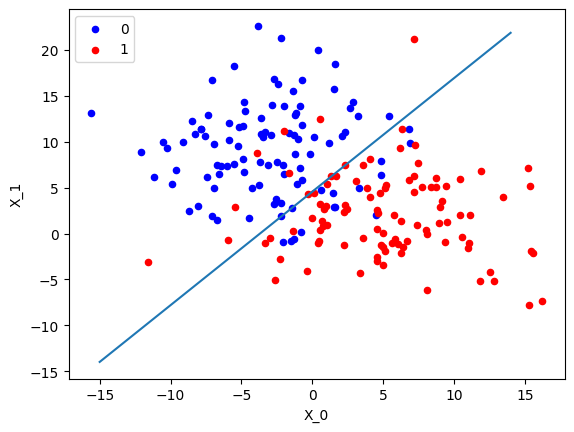

In [125]:
def view_logistic_split(w, X, x_range):
    x = np.array(x_range)
    #y is the same as what we were considering x2; just another way to express one class in terms of the other
    y = -(w[0] + w[1] * x) / w[2]  # Correct decision boundary equation

    return x, y

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'blue', 1:'red'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for k, v in grouped:
    v.plot(ax=ax, kind='scatter', x='x', y='y', label=k, color=colors[k])

x_view, y_view = view_logistic_split(w, X, range(-15,15))
plt.plot(x_view, y_view)

plt.xlabel('X_0')
plt.ylabel('X_1')
plt.show()

### Multivariate Logistic Regression

In [126]:
from sklearn.datasets._samples_generator import make_blobs
X, y = make_blobs(n_samples=200, centers=3, n_features=3, cluster_std=5, random_state=200)

In [127]:
df_1 = pd.DataFrame({'x1': X[:, 1], 'x2': X[:, 2], 'y': y, 'label': y})
df_2 = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y, 'label': y})
df_3 = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 2], 'y': y, 'label': y})

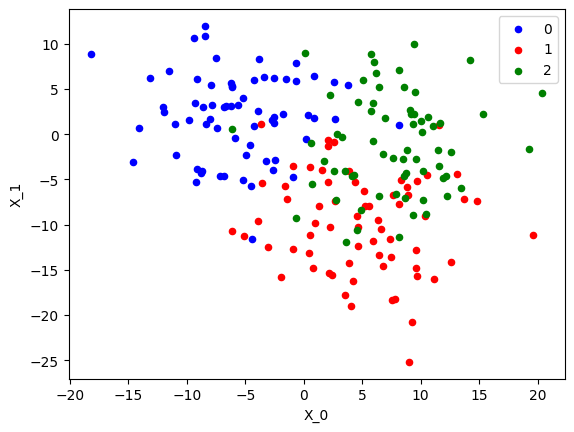

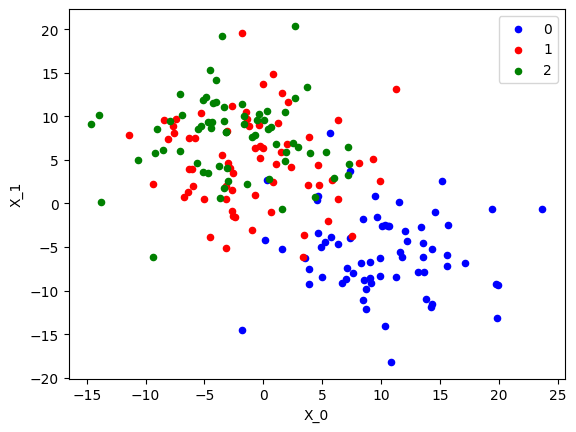

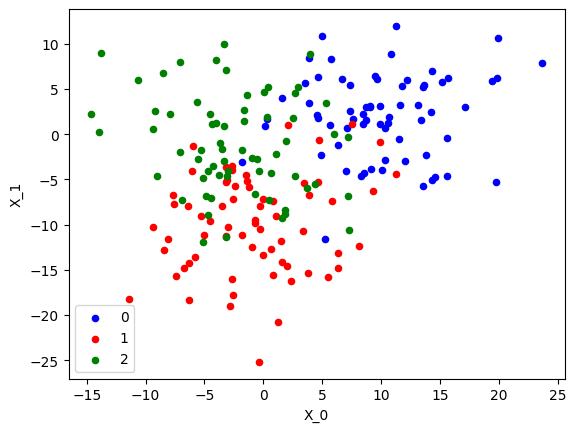

In [128]:
for df in [df_1,df_2,df_3]:
    
    colors = {0:'blue', 1:'red', 2:'green'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')

    for k, v in grouped:
        v.plot(ax=ax, kind='scatter', x='x1', y='x2', label=k, color=colors[k])

    plt.xlabel('X_0')
    plt.ylabel('X_1')
    plt.show()

In [129]:
import torch
from torch.nn import functional as F
class ManualLogisticRegression():
    def __init__(self):
        self.w = None
        self.b = None


    def predict(self, X):
        y_pred_linear =  X @ self.w + self.b # Linear transformation
        y_pred = F.softmax(y_pred_linear, 1) # Softmax for multi-class probabilities
        return y_pred


    def compute_loss(self, X, y):
        y_pred = self.predict(X)
        loss = -torch.sum(y * torch.log(y_pred)) / X.shape[0]  # Cross-entropy loss; not binary cross entropy
        return loss


    def compute_grad(self, X, y):
        y_pred = self.predict(X)
        error = y_pred - y

        w_grad = X.T @ error / X.shape[0]  # Weight gradient
        b_grad = torch.sum(error, dim=0) / X.shape[0]  # Bias gradient

        return w_grad, b_grad


    def fit(self, X, y, lr=0.01, max_epochs=100):
        X = torch.tensor(X, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)

        n_feat = X.shape[1]
        n_classes = len(torch.unique(y))  # Get number of classes dynamically

        self.w = torch.randn(n_feat, n_classes) * torch.sqrt(torch.tensor(2.0 / n_feat)) #kaiming normal initialization
        self.b = torch.zeros(n_classes)

        y_one_hot = F.one_hot(y, num_classes=n_classes).float()
        epoch=0

        while True:
            w_grad, b_grad = self.compute_grad(X,y_one_hot)
            self.w -= lr*w_grad
            self.b -= lr*b_grad
            epoch+=1


            if epoch % 10 == 0:  # Print loss every 10 epochs
                loss = self.compute_loss(X, y_one_hot)
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

            if epoch == max_epochs:
                break


In [153]:
import numpy as np

class ManualMultinomialLogisticRegression():
    def __init__(self, learning_rate=0.01, max_iter=1000, tolerance=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.w = None
        self.b = None

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))  # for numerical stability
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def compute_loss(self, X, y):
        # Number of samples
        m = X.shape[0]
        
        # Compute the predictions
        scores = X.dot(self.w) + self.b  # Linear transformation
        y_pred = self.softmax(scores)

        # One-hot encode the true labels
        y_one_hot = np.eye(self.w.shape[1])[y]

        # Compute cross-entropy loss
        log_likelihood = -np.log(np.sum(y_one_hot * y_pred, axis=1))
        loss = np.sum(log_likelihood) / m
        return loss

    def compute_gradients(self, X, y):
        # Number of samples
        m = X.shape[0]

        # Compute the predictions
        scores = X.dot(self.w) + self.b
        y_pred = self.softmax(scores)

        # One-hot encode the true labels
        y_one_hot = np.eye(self.w.shape[1])[y]

        # Gradients for weights (w) and bias (b)
        error = y_pred - y_one_hot
        w_grad = X.T.dot(error) / m
        b_grad = np.sum(error, axis=0) / m

        return w_grad, b_grad

    def fit(self, X, y):
        # Initialize weights and bias
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Initialize weights (random initialization)
        self.w = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros(n_classes)

        # Gradient descent loop
        prev_loss = float('inf')
        for epoch in range(self.max_iter):
            # Compute gradients
            w_grad, b_grad = self.compute_gradients(X, y)

            # Update weights and bias
            self.w -= self.learning_rate * w_grad
            self.b -= self.learning_rate * b_grad

            # Compute the current loss
            loss = self.compute_loss(X, y)

            # Check for convergence (if the loss change is small)
            if np.abs(prev_loss - loss) < self.tolerance:
                print(f"Converged after {epoch+1} iterations")
                break

            prev_loss = loss

            # Print loss every 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return self

    def predict(self, X):
        scores = X.dot(self.w) + self.b
        y_pred = self.softmax(scores)
        return np.argmax(y_pred, axis=1)  # Return the class with highest probability

    def predict_proba(self, X):
        scores = X.dot(self.w) + self.b
        return self.softmax(scores)


In [154]:
nl = MultinomialLogisticRegression()
nl.fit(X,y)

Epoch 0: Loss = 0.5816
Epoch 50: Loss = 0.4972
Epoch 100: Loss = 0.4926
Epoch 150: Loss = 0.4896
Epoch 200: Loss = 0.4876
Epoch 250: Loss = 0.4864
Epoch 300: Loss = 0.4855
Epoch 350: Loss = 0.4849
Epoch 400: Loss = 0.4845
Epoch 450: Loss = 0.4842


In [156]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def compute_loss(w, X, Y):
    y_pred = hx(w, X)  # Assuming hx function is defined somewhere
    return -1 * sum(Y * np.log(y_pred) + (1 - Y) * np.log(1 - y_pred))

X, y = make_blobs(n_samples=200, centers=3, n_features=3, cluster_std=5, random_state=200)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, verbose=1)
model.fit(X, y)

# Access the loss curve attribute if available
losses = model.loss_curve_

# Plot the loss curve
plt.plot(losses)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


/Users/richardlottes/Desktop/code/ml_from_scratch/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


AttributeError: 'LogisticRegression' object has no attribute 'loss_curve_'

In [157]:
import sklearn
print(sklearn.__version__)


1.6.1
